# Language Classification with Naive Bayes in Python

## Recommended Prerequisites for Successful Completion
* Intermediate level understanding of Python 3+ (e.g. list and dictionary comprehension)
* Basics of machine learning (e.g. the distinction between training and validation data)
* Mathematical probability (e.g. understanding Bayes' Theorem at a basic level)


In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [2]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [3]:
data_raw = {}
data_raw['sk'] = open_file('train_sentences.sk')
data_raw['cs'] = open_file('train_sentences.cs')
data_raw['en'] = open_file(train_sentences.en')

In [16]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        number_of_words = len(word_list)
        number_of_sentences = len(sentences)
        number_of_unique_words = len(set(word_list))
        sample_extract = ' '.join(word_list[0:7])
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [17]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...



<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [25]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
    
    preprocessed_text = text
    preprocessed_text = text.lower().replace('-',' ')
    translation_table = str.maketrans('\n',' ',string.punctuation+string.digits)
    preprocessed_text = preprocessed_text.translate(translation_table)
    
    return preprocessed_text

In [26]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k,v in data_raw.items()}

In [28]:
show_statistics(data_preprocessed)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2366
Number of unique words	:	 904
Sample extract		:	 i can understand your approach a little...



<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

## Vectorizing Training Data

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [37]:
y_sentences, y_train = [],[]
for k,v in data_preprocessed.items():
    for sentence in v:
        y_sentences.append(sentence)
        y_train.append(k)

In [38]:
vectorizer = CountVectorizer()

In [39]:
X_train = vectorizer.fit_transform(y_sentences)

## Initializing Model Parameters and Training

In [40]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [42]:
data_validation = dict()

data_validation['sk'] = open_file('val_sentences.sk')
data_validation['cs'] = open_file('val_sentences.cs')
data_validation['en'] = open_file('val_sentences.en')

In [43]:
data_validation_preprocessed = {k: [preprocess(sentence) for sentence in v] for k,v in data_validation.items()}

In [46]:
sentences_val, y_val = [],[]
for k,v in data_validation_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [47]:
X_val = vectorizer.transform(sentences_val)

In [48]:
predictions = naive_classifier.predict(X_val)

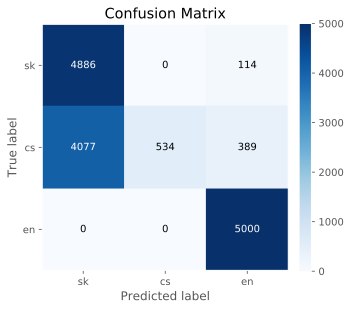

In [50]:
plot_confusion_matrix(y_val, predictions, ['sk','cs','en'])

In [54]:
f1_score(y_val,predictions,average='weighted')

0.6149824401040264

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

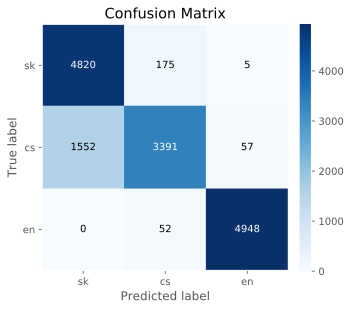

In [64]:
naive_classifier_ennhanced = MultinomialNB(alpha=0.1, fit_prior=False)

naive_classifier_ennhanced.fit(X_train,y_train)
new_predictions = naive_classifier_ennhanced.predict(X_val)

plot_confusion_matrix(y_val,new_predictions,['sk','cs','en'])
# We expect great improvemens in the confusion matrix

In [65]:
f1_score(y_val,new_predictions,average='weighted')
# Again we ecpect huge improvements in F1 Score as well

0.874421671678189

In [63]:
# We improved by about 26% which is a huge improvement from our previous F1 score

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [66]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [67]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [68]:
vocab = get_vocab(y_sentences)

In [69]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [70]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [71]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [72]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [73]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [74]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [75]:
data_preprocessed_subwords

{'sk': ['de an de al as ne as ve li vy ak je an pr ho no in ie de er or mu re vy ad že in ia de to me po al re la bo it ia le al aj že al na na me st ov ie pr',
  'by ke me sa po ne li si ne mo né ak by me li mo ia do en',
  'il že ci bu de sa st ch or vý re an né ve ci',
  'ed ie by sa mo lo ať že de al bo po te vo ct',
  'je om je ie en ov ať ve ak la st ie st me ne pr áv st ed at ne po pr ce re st ch ch ia ve by sa sk ur om ar on po li sk in ie or re po né na ne pr áv po it ic re la né en ie ho no',
  'na ie ia do to to ie je ne ia or mi it le by en sk ed li av pr at re ia at po al ov pr',
  'an re ed aj re ed ro ar so st an ov il ro ie st la ro by vý it ov ne en er ie ie om is ie en ov ch sk ov ly be to ho by sa li na ia vy na st ra',
  'to po ia av ak ie je st to ne do ne pr an ov or mu po ia de om sk',
  'pr vo aj en an re ed aj is ia ro vý ch mo ov le te mi li re en ed že re po né pr av že re po né il né po ia av to by sa li mo st ať in po mi že je re po il en ra',
  'ne me mu v

In [76]:
data_train_subwords = []
for sentence in y_sentences:
    data_train_subwords.append(split_into_subwords(sentence))

In [77]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [78]:
vectorizer_sub = CountVectorizer()

In [79]:
X_train_sub = vectorizer_sub.fit_transform(data_train_subwords)
X_val_sub = vectorizer_sub.transform(data_val_subwords)

In [90]:
naive_classifier_sub = MultinomialNB(alpha=0.9,fit_prior=False)
naive_classifier_sub.fit(X_train_sub,y_train)
predictions_sub = naive_classifier_sub.predict(X_val_sub)

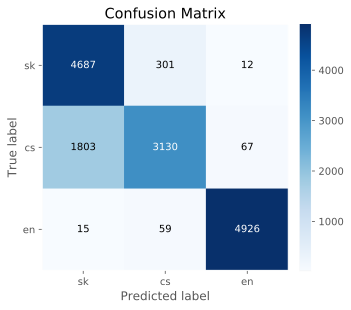

In [91]:
plot_confusion_matrix(y_val,predictions_sub,['sk','cs','en'])

In [92]:
f1_score(y_val, predictions_sub,average='weighted')

0.8456072917343868